## Atividade de análise de sentimentos em texto com base de dados IMDB

Aluno: João Guilherme Lopes Alves da Costa

Professor: Ranniery da Silva Maia

Disciplina: DIM0446 - APRENDIZADO PROFUNDO

In [ ]:
# Definição das bibliotecas a serem utilizadas no notebook, como a base de dados IMDB
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.datasets import imdb
from tensorflow.keras import models, layers, optimizers, losses, metrics
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns

Aqui foi definido algumas configurações de parâmetros a serem utilizadas no treinamento, como número de épocas, o tamanho do batch, o número máximo de palavras, entre outros.

In [ ]:
h = {
    'MAX_WORD_INDEX': 10000,
    'VAL_PERC': 0.1,
    'EMBEDDING_DIM': 16,
    'NUM_LSTM_UNITS': 16,
    'LR': 0.001,
    'BETA1': 0.9,
    'BETA2': 0.999,
    'EPSILON': 1.0e-8,
    'DECAY': 0.0,
    'NUM_EPOCHS': 10,
    'BATCH_SIZE': 32
}


In [ ]:
# Carregamento da base de dados e separação entre dados de treino e teste
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=h['MAX_WORD_INDEX'])

Aqui faremos a exploração na base de dados para entender melhor que informações temos, então obtemos a sequência máxima de treinamento de teste e de treino e a menor sequência. 'Sequência' aqui definido seria o maior texto.

In [ ]:
max_seq_len_train = max([len(sequence) for sequence in train_data])
print(f'Tamanho da maior sequência (treino): {max_seq_len_train}')
max_seq_len_test = max([len(sequence) for sequence in test_data])
print(f'Tamanho da maior sequência (test): {max_seq_len_test}')
min_seq_len_train = min([len(sequence) for sequence in train_data])
print(f'Tamanho da menor sequẽncia (treino): {min_seq_len_train}')
min_seq_len_test = min([len(sequence) for sequence in test_data])
print(f'Tamanho da menor sequência (test): {min_seq_len_test}')

Tamanho da maior sequência (treino): 2494
Tamanho da maior sequência (test): 2315
Tamanho da menor sequẽncia (treino): 11
Tamanho da menor sequência (test): 7


In [ ]:
print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(25000,)
(25000,)
(25000,)
(25000,)


O texto da base de dados já está tokenizado, cada palavra já tem um número associado, aqui faremos o processo inverso, pegaremos a lista de tokens, pegaremos um exemplo aleatório e reverteremos para mostrar a descrição. Caso o índice da palavra não existir no dicionário é adicionado um '?'.

In [ ]:
word_index = imdb.get_word_index()
ind = 20000
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[ind]])
print(decoded_review)
print(train_data[ind])
print(train_labels[ind])

? a young woman suffers from the ? that she is a werewolf based upon a family legend of an ? accused of and killed for allegedly being one due to her past treatment by men she travels the countryside ? and killing the men she meets falling in love with a kind man her life appears to take a turn for the better when she is raped and her lover is killed by a band of thugs traumatized again by these latest events the woman returns to her violent ways and seeks revenge on the thugs according to the dvd ? synopsis br br ? ? ? la ? ? begins with full frontal ? ? dance by ? blonde ? ? who as ? ? ? believes she is a werewolf the ? part is when the camera catches background fire between her legs the opening flashback reveals her hairy ? was probably a ? creature ms ? is unfortunately not a werewolf she is merely a very strong lunatic br br as a film werewolf woman in english would have been better if ? character really was a female werewolf with her sexual ? a great bit of characterization but a

Agora iremos padronizar, ou melhor, normalizar os dados para torna-los consistentes no treinamento, transformando todos os dados para o mesmo comprimento.

In [ ]:
X_train = keras.preprocessing.sequence.pad_sequences(train_data)
print(X_train.shape)
X_test = keras.preprocessing.sequence.pad_sequences(test_data, maxlen=X_train.shape[-1])
print(X_test.shape)

(25000, 2494)
(25000, 2494)


In [ ]:
# A conversão para float32 é necessária para compatibilidade com o modelo Keras.
y_train = np.asarray(train_labels).astype('float32')
print(y_train.shape)
y_test = np.asarray(test_labels).astype('float32')
print(y_test.shape)

(25000,)
(25000,)


In [ ]:
# Aqui estamos definindo a quantidade de dados que irá para treino e quanto irá para validação
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=h['VAL_PERC'])
print(X_train_final.shape)
print(X_val.shape)
print(y_train_final.shape)
print(y_val.shape)

(22500, 2494)
(2500, 2494)
(22500,)
(2500,)


### Definição do modelo

Aqui estamos construindo nosso modelo de aprendizado profundo (rede neural sequencial) para conseguirmos fazer a classificação binária de sentimentos.

Então definimos o modelo sequencial, em seguida definimos algumas camadas como de **embedding**, que irá converter tokens (palavras representadas por índices inteiros) em vetores.

Definidos uma camada de LSTM (Long Short-Term Memory), um tipo de rede neural recorrente para processamento de sequências, nesse caso de tokens.

Por fim, uma camada densa de saída com apenas 1 unidade, que irá converter para valor 0 ou 1, definindo se será positiva (1) ou negativa (0).

In [ ]:
model1 = models.Sequential()
model1.add(layers.Embedding(h['MAX_WORD_INDEX'], h['EMBEDDING_DIM']))
model1.add(layers.LSTM(units=h['NUM_LSTM_UNITS']))
model1.add(layers.Dense(1, activation='sigmoid'))
print(model1.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


Aqui será feito a compilação do modelo, utilizando parâmetros definidos no início do notebook. Além disso, é difinido as métricas utilizadas para avaliação do modelo.

In [ ]:
opt = optimizers.Adam(learning_rate=h['LR'],
                      beta_1=h['BETA1'],
                      beta_2=h['BETA2'],
                      epsilon=h['EPSILON'])

loss = losses.binary_crossentropy
metric = metrics.BinaryAccuracy()

model1.compile(optimizer=opt, loss=loss, metrics=[metric])

Define uma lista de callbacks com EarlyStopping, que servirá para monitor o treinamento e interrompê-lo caso a métrica binary_accuracy não melhorar após 5 épocas, ajudando a evitar sobreajuste.

In [ ]:
calback_list = [
    EarlyStopping(monitor='binary_accuracy',
                  mode='max',
                  patience=5)]

In [ ]:
# Realização do treinamento do modelo com 10 épocas
history1 = model1.fit(X_train_final,
                      y_train_final,
                      epochs=h['NUM_EPOCHS'],
                      batch_size=h['BATCH_SIZE'],
                      shuffle=True,
                      validation_data=(X_val, y_val),
                      callbacks=calback_list)

Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 55s 71ms/step - binary_accuracy: 0.7413 - loss: 0.5129 - val_binary_accuracy: 0.8732 - val_loss: 0.3126
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 49s 69ms/step - binary_accuracy: 0.9063 - loss: 0.2421 - val_binary_accuracy: 0.8600 - val_loss: 0.3260
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 82s 70ms/step - binary_accuracy: 0.9294 - loss: 0.1978 - val_binary_accuracy: 0.8884 - val_loss: 0.3288
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 49s 70ms/step - binary_accuracy: 0.9443 - loss: 0.1525 - val_binary_accuracy: 0.8836 - val_loss: 0.3256
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 83s 71ms/step - binary_accuracy: 0.9533 - loss: 0.1291 - val_binary_accuracy: 0.8804 - val_loss: 0.3440
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 81s 70ms/step - binary_accuracy: 0.9717 - loss: 0.0868 - val_binary_accuracy: 0.8728 - val_loss: 0.3950
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 83s 72ms/step - binary_accuracy: 0.9687 - loss: 0.0941 - val_binary_accuracy: 0.7300 - val_loss:

Agora, teremos a avaliação através do uso de gráficos e matriz de confusão para determinamos se o nosso modelo é bom. Os gráficos podemos ver a evolução da perda e da acurácia do modelo durante o treinamento e validação.

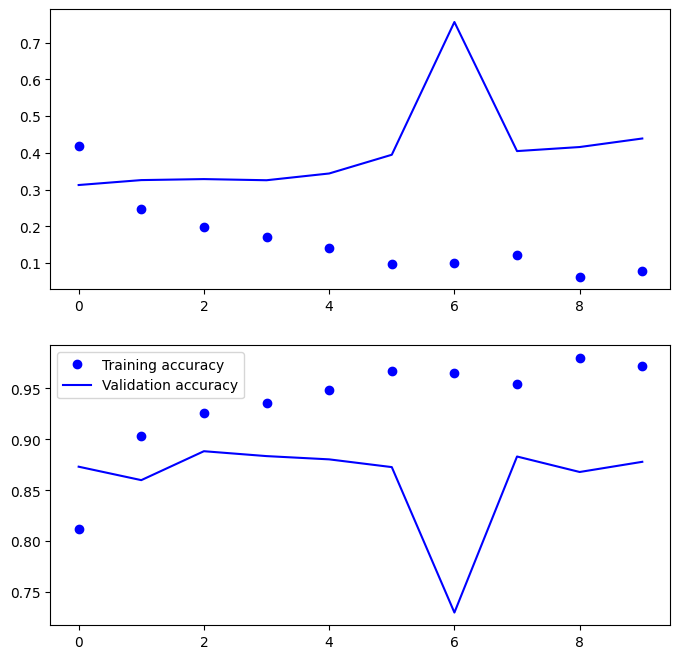

In [ ]:
history_dict = history1.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']

epochs = range(h['NUM_EPOCHS'])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))

ax1.plot(epochs, loss_values, 'bo', label='Training loss')
ax1.plot(epochs, val_loss_values, 'b', label='Validation loss')

ax2.plot(epochs, acc_values, 'bo', label='Training accuracy')
ax2.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
ax2.legend()

plt.show()

In [ ]:
y_test_hat_mod = model1.predict(X_test)

782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step


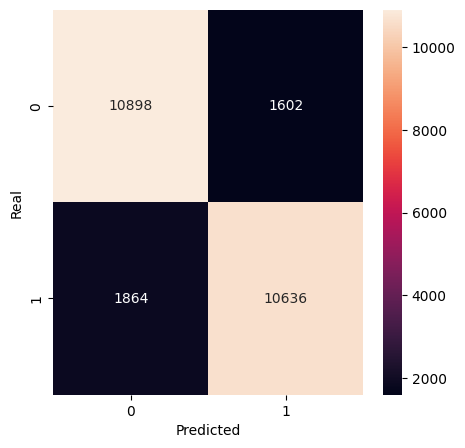

In [ ]:
y_test_hat_bin = np.where(y_test_hat_mod > 0.5, 1, 0)

cm = confusion_matrix(y_test, y_test_hat_bin)
fig = plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='4d')
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.show()

Aqui foi tentado treinar o modelo com 30 épocas, porém, o máximo conseguido foi com 25 épocas pois o modelo parou antes de finalizar devido a lista de callbacks que definimos com o EarlyStopping.

In [ ]:
history2 = model1.fit(X_train_final,
                      y_train_final,
                      epochs=30,
                      batch_size=h['BATCH_SIZE'],
                      shuffle=True,
                      validation_data=(X_val, y_val),
                      callbacks=calback_list)

Epoch 1/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 52s 71ms/step - binary_accuracy: 0.6603 - loss: 0.5948 - val_binary_accuracy: 0.8492 - val_loss: 0.3685
Epoch 2/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 50s 71ms/step - binary_accuracy: 0.8857 - loss: 0.2936 - val_binary_accuracy: 0.8844 - val_loss: 0.2912
Epoch 3/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 83s 72ms/step - binary_accuracy: 0.9254 - loss: 0.2067 - val_binary_accuracy: 0.8840 - val_loss: 0.2980
Epoch 4/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 81s 71ms/step - binary_accuracy: 0.9439 - loss: 0.1637 - val_binary_accuracy: 0.8336 - val_loss: 0.3751
Epoch 5/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 82s 71ms/step - binary_accuracy: 0.9425 - loss: 0.1620 - val_binary_accuracy: 0.8660 - val_loss: 0.3273
Epoch 6/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 82s 71ms/step - binary_accuracy: 0.9641 - loss: 0.1145 - val_binary_accuracy: 0.8592 - val_loss: 0.3595
Epoch 7/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 84s 74ms/step - binary_accuracy: 0.9592 - loss: 0.1259 - val_binary_accuracy: 0.8620 - val_loss:

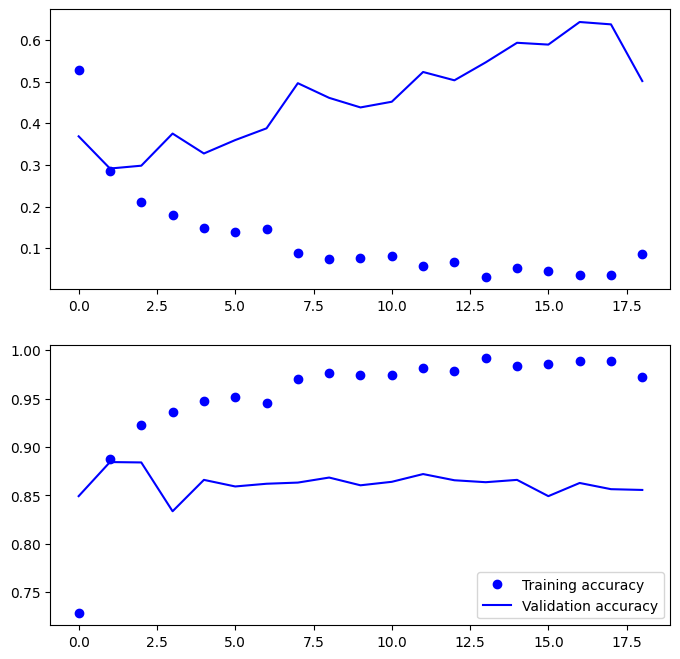

In [ ]:
history_dict = history2.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']

epochs = range(19)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))

ax1.plot(epochs, loss_values, 'bo', label='Training loss')
ax1.plot(epochs, val_loss_values, 'b', label='Validation loss')

ax2.plot(epochs, acc_values, 'bo', label='Training accuracy')
ax2.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
ax2.legend()

plt.show()

In [ ]:
y_test_hat_mod = model1.predict(X_test)

782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step


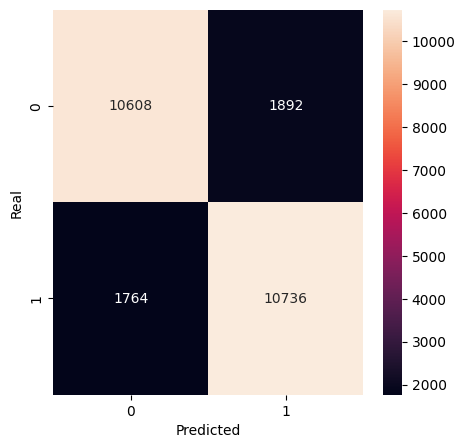

In [ ]:
y_test_hat_bin = np.where(y_test_hat_mod > 0.5, 1, 0)

cm = confusion_matrix(y_test, y_test_hat_bin)
fig = plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='4d')
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.show()

No último teste que fiz foi até 19 épocas, e o desempenho não foi melhor significativamente.